# `Stan` Week!  Lecture 2
![alt text](stan2.jpg)


## Example 1: Rats!
On Tuesday we saw examples of some simple models in `Stan`. HMC worked fairly well for these cases, and we had no `Stan` warnings. Now let's turn to a slightly more complex example, which will cause some problems.  

Say we've performed several repetitions of an experiment where rats are intoxicated by a substance, and then treated with either a drug, or left alone. In each experiment, we record some response varialbe for $n$ rats (say blood pressure), and then average across individuals. We'd like to combine the data from these experiments in a principled way, to estimate the effect of the drug. To do so, we'll use a Bayesian hierarchical model: 
$$
\begin{split}
\text{control: }x_{i} &\sim N(\theta_i,\sigma_c^2)\\
\text{drug treatment: }y_{i} &\sim N(\theta_i + \delta_i,\sigma_t^2)\\
\end{split}
$$
Where $x_i$ and $y_i$ denote the sample means of the response variables over $i=1,...,I$ trials for both the control.

We'll apply the following priors:
$$
\begin{split}
\theta_i &\sim N(\mu_{\theta},\sigma_{\theta}^2)\\
\delta_i &\sim N(\mu_{\delta},\sigma_{\delta}^2)\\
\sigma_c &\sim IG(1,10)\\
\sigma_t &\sim IG(1,10)\\
\end{split}
$$

And the following hyperpriors:
$$
\begin{split}
\mu_{\theta} &\sim N(0,20)\\
\mu_{\delta} &\sim N(0,20)\\
\sigma_{\theta}^2 &\sim \text{unif}(0,10^6)\\
\sigma_{\delta}^2 &\sim \text{unif}(0,10^6)\\
\end{split}
$$

We want to jointly estimate the following parameters:
$$
\mu_{\theta},\mu_{\delta},\sigma_{\theta}^2,\sigma_{\delta}^2,\sigma_{c}^2,\sigma_{a}^2,\sigma_{t}^2
$$

Let's look at how we would handle this model in `Stan`:

In [114]:
library(rstan)
set.seed(8675309)
stan.mod = "
data {
  int I; // number of trials
  vector[I] x; // control outcomes
  vector[I] y; // drug outcomes
}

parameters {
  // model parameters
  vector[I] theta;
  vector[I] delta;
  real<lower=0> sig_c;
  real<lower=0> sig_t;

  // hyperparameters
  real mu_theta;
  real mu_delta;
  real<lower=0> sig_theta;
  real<lower=0> sig_delta;

}

model {
  // hyperpriors
  // Stan defaults to improper uniform priors:
  //mu_theta ~ normal(0,20); 
  //mu_delta ~ normal(0,20); 

  sig_delta ~ uniform(0,1e6);
  sig_theta ~ uniform(0,1e6); 

  // model priors 
  theta ~ normal(mu_theta,sig_theta);
  delta ~ normal(mu_delta,sig_delta);

  sig_c ~ inv_gamma(1,10);
  sig_t ~ inv_gamma(1,10);

  // likelihood
  x ~ normal(theta,sig_c);
  y ~ normal(theta+delta,sig_t);
}
"

# sample some fake data
mu_theta = 1
mu_delta = 2

sig_theta = .1
sig_delta = .1

sig_c = 1
sig_t = 1

# sample latent parameters
I = 50
theta = rnorm(I,mu_theta,sig_theta)
delta = rnorm(I,mu_delta,sig_delta)

x = rnorm(I,theta,sig_c)
y = rnorm(I,theta+delta,sig_t)

stan.dat = list('x'=x,'y'=y)

nsamps = 1e4
chains = 4
seed = 8675309
# FOR ILLUSTRATION PURPOSES:
fit = stan(model_code = stan.mod,
           data=stan.dat,
           chains=chains,
           iter=nsamps,
           seed=seed,
           control=list(adapt_delta=0.99))



SAMPLING FOR MODEL 'c1b7fc2d1b83abd5eb3b60fafb990e79' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 11.0961 seconds (Warm-up)
Chain 1:                39.1217 seconds 

Warning message:
“There were 3412 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 8190 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

Warning messages! **Rats!**

We'll talk about divergent transitions more on Thursday, but for now the basic idea is that a divergent transition occurs when the proposal trajectories experiences some numerical errors. Although `Stan` will shrug these off and continue sampling, divergences in our model impact the validity of our estimates, since any divergent proposal breaks the assumptions necessary for HMC to converge to the posterior. Sometimes divergences can be dealt with by increasing the `adapt_delta` parameter, but if they are persistent it's likely there is either an error in your model code, or your posterior structure is causing HMC to  struggle. 

Divergences little cousin is the "maximum treedepth" warning. This occurs when the `NUTS` sampler maxes out its search for $L$, without seeing a U-turn. These often co-occur with divergences, however are not as serious. From the `Stan` user guide:
> While divergent transitions are a **validity** concern, hitting the maximum treedepth is an **efficiency** concern.

Finally, the BMFI warning. Again this typically co-occurs with divergent transitions. It indicates that the burn-in phase of the chains did not go well, and that the chains are likely not converged to the true distribution.   

Let's use some of the diagnostic plots to figure out what may be causing the divergences, and we'll see how to fix them next time: 

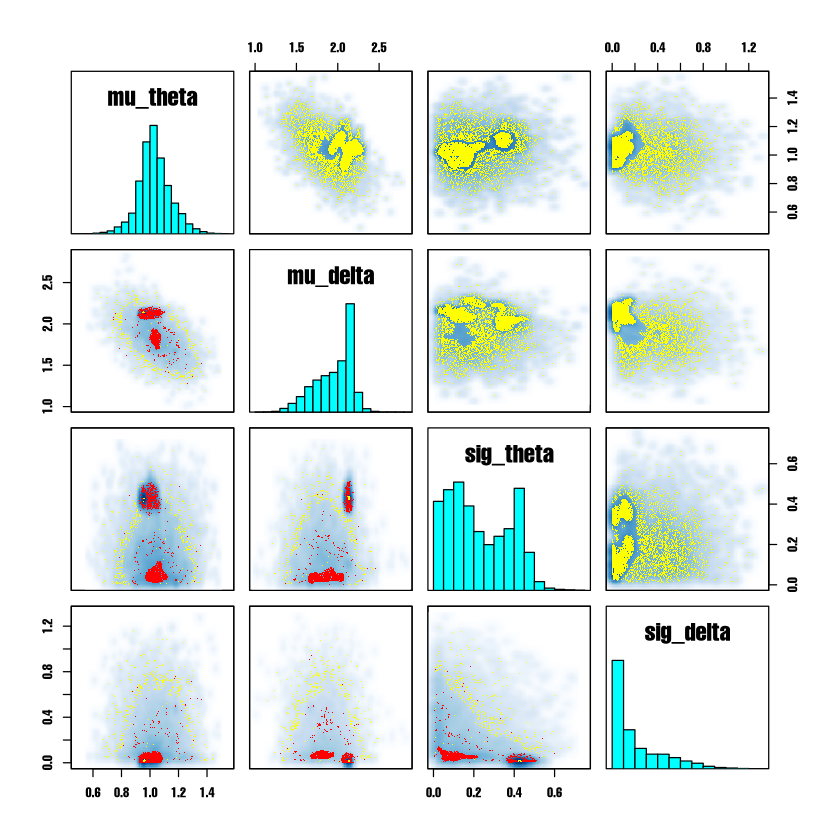

In [119]:
pairs(fit,pars=c('mu_theta','mu_delta','sig_theta','sig_delta'))

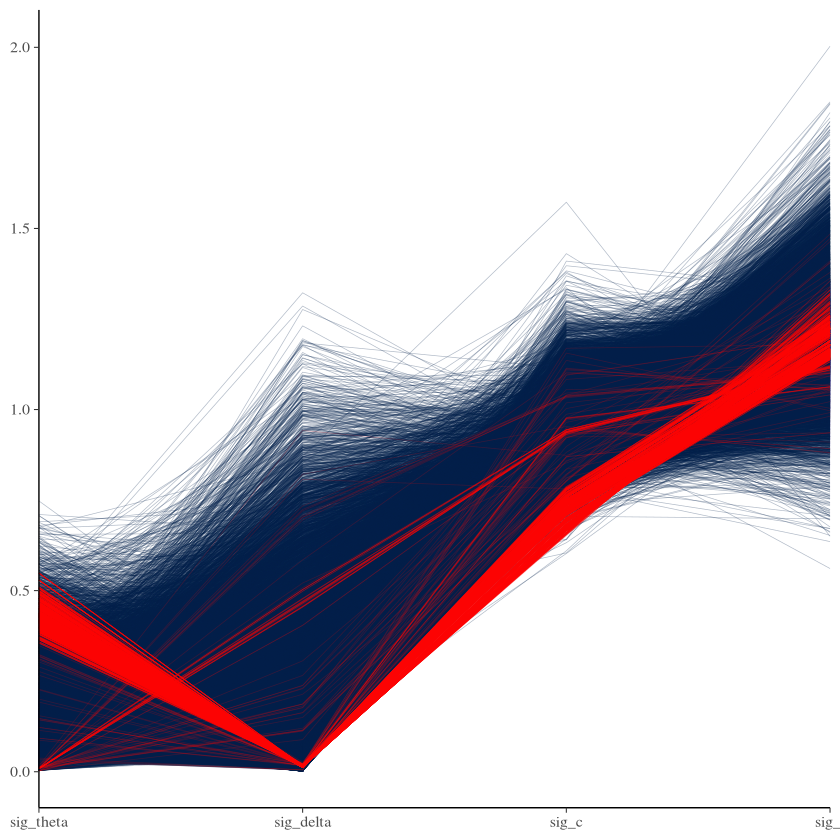

In [118]:
np = nuts_params(fit)
mcmc_parcoord(as.array(fit),pars=c('sig_theta','sig_delta','sig_c','sig_t'),np=np)

It turns out that fixing the divergences is actually somewhat simple, we just need to reparameterize our model. We'll say that $\theta_i = \mu_{\theta} + \tau_i^{\theta}\sigma_{\theta}$, and that $\tau_{\theta} \sim N(0,1)$ (and similarl for $\delta_i$). Our model is then:

$$
\begin{split}
\text{control: }x_{i} &\sim N(\mu_{\theta} + \tau_i^{\theta}\sigma_{\theta},\sigma_c^2)\\
\text{drug treatment: }y_{i} &\sim N(\mu_{\theta} + \tau_i^{\theta}\sigma_{\theta} + \mu_{\delta} + \tau_i^{\delta}\sigma_{\delta},\sigma_t^2)\\
\end{split}
$$

With priors:
$$
\begin{split}
\tau_i^{\theta} &\sim N(0,1)\\
\tau_i^{\delta} &\sim N(0,1)\\
\sigma_c &\sim IG(1,10)\\
\sigma_t &\sim IG(1,10)\\
\end{split}
$$

And the same hyperpriors:
$$
\begin{split}
\mu_{\theta} &\sim N(0,20)\\
\mu_{\delta} &\sim N(0,20)\\
\sigma_{\theta}^2 &\sim \text{unif}(0,10^6)\\
\sigma_{\delta}^2 &\sim \text{unif}(0,10^6)\\
\end{split}
$$

In [115]:
library(rstan)
set.seed(8675309)
stan.mod.ncp = "
data {
  int I; // number of trials
  vector[I] x; // control outcomes
  vector[I] y; // drug outcomes
}

parameters {
  // model parameters
  vector[I] tau_theta;
  vector[I] tau_delta;
  real<lower=0> sig_c;
  real<lower=0> sig_t;

  // hyperparameters
  real mu_theta;
  real mu_delta;
  real<lower=0> sig_theta;
  real<lower=0> sig_delta; 
}

transformed parameters {
  vector[I] theta;
  vector[I] delta;

  theta = mu_theta + tau_theta*sig_theta;
  delta = mu_delta + tau_delta*sig_delta;
}

model {
  // hyperpriors
  // Stan defaults to improper uniform priors:
  //mu_theta ~ normal(0,20); 
  //mu_delta ~ normal(0,20); 

  sig_delta ~ uniform(0,1e6);
  sig_theta ~ uniform(0,1e6); 

  // model priors 
  tau_theta ~ normal(0,1);
  tau_delta ~ normal(0,1);

  sig_c ~ inv_gamma(1,10);
  sig_t ~ inv_gamma(1,10);

  // likelihood
  x ~ normal(theta,sig_c);
  y ~ normal(delta,sig_t);
}
"

fit.ncp = stan(model_code = stan.mod.ncp,
           data=stan.dat,
           chains=chains,
           iter=nsamps,
           seed=seed,
           control=list(adapt_delta=0.99) )



SAMPLING FOR MODEL 'a3ec81714638c2ce30117fa0f5af6613' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 3.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 6.6839 seconds (Warm-up)
Chain 1:                5.19488 seconds (

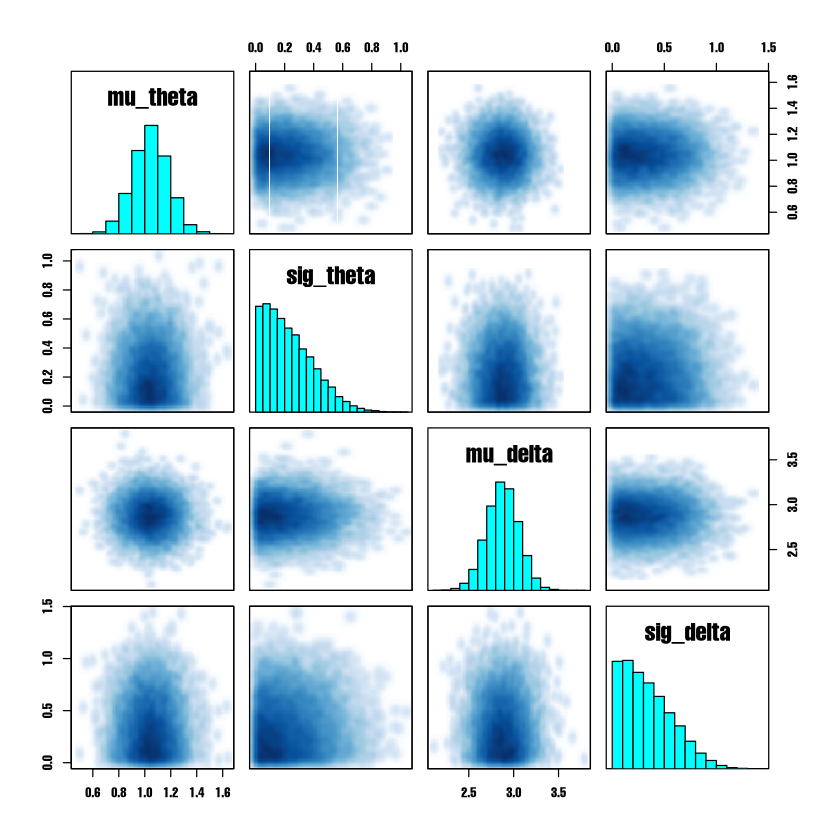

In [116]:
pairs(fit.ncp,pars=c('mu_theta','sig_theta','mu_delta','sig_delta'))

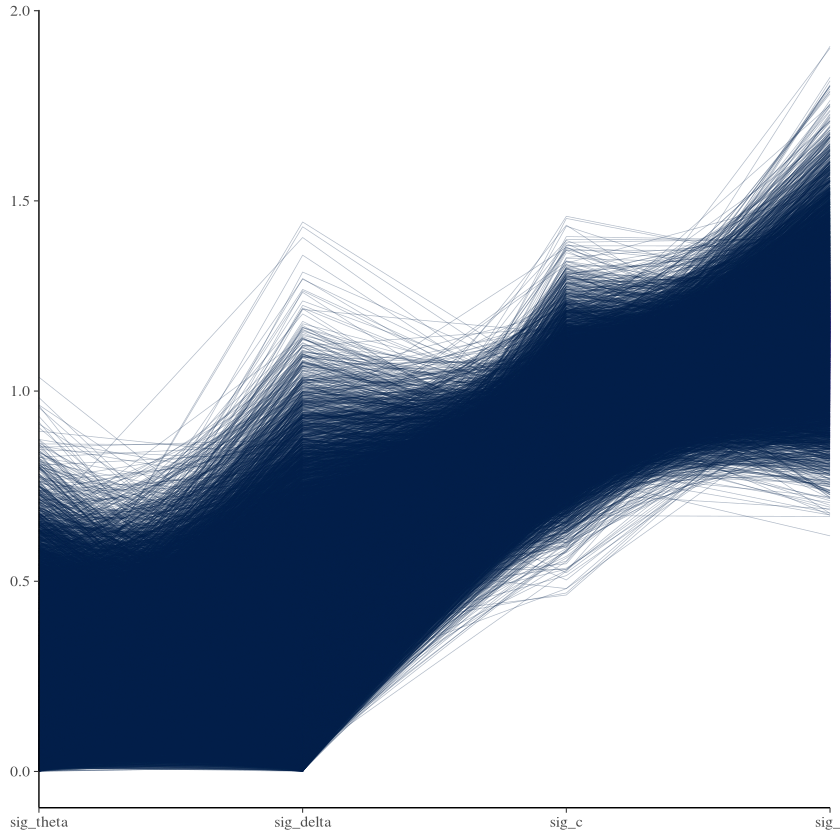

In [120]:
np.ncp = nuts_params(fit.ncp)
mcmc_parcoord(as.array(fit.ncp),pars=c('sig_theta','sig_delta','sig_c','sig_t'),np=np.ncp)